In [33]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd

from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Our very own survLime!
import survLime
from survLime.utils.generic_utils import fill_matrix_with_total_times
from survLime.datasets.load_datasets import Loader 
from survLime import survlime_tabular


loader = Loader(dataset_name='udca')
x,events, times = loader.load_data()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/carlos.hernandez/dl/lib/python3.8/site-packages/pandas/core/series.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [34]:
train, val, test = loader.preprocess_datasets(x, events, times)
events_train = [x[0] for x in train[1]]
times_train  = [x[1] for x in train[1]]

events_val = [x[0] for x in val[1]]
times_val  = [x[1] for x in val[1]]

events_test = [x[0] for x in test[1]]
times_test  = [x[1] for x in test[1]]

In [35]:
model = CoxPHSurvivalAnalysis(alpha=0.0001)
#model = RandomSurvivalForest()
model.fit(train[0], train[1])
model.score(test[0], test[1])

0.7971014492753623

## Code trials to have it all on the explainer


In [10]:
# Step two
from sksurv.nonparametric import nelson_aalen_estimator
from functools import partial
import cvxpy as cp
from math import log
import timeit
import sklearn

times_to_fill = list(set(times_train)); times_to_fill.sort()
columns = test[0].columns.tolist()
num_pat = 500

explainer = survlime_tabular.LimeTabularExplainer(train[0], target_data=train[1], feature_names=columns, class_names=None,
                                                   categorical_features=None, verbose=True, mode='regression', discretize_continuous=False)

H_i_j_wc, weights, log_correction, Ho_t_, scaled_data = \
                    explainer.explain_instance(test[0].iloc[0], model.predict_survival_function)

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


In [ ]:
from tqdm import tqdm

times_to_fill = list(set(times_train)); times_to_fill.sort()
columns = test[0].columns.tolist()
num_pat = 500

explainer = survlime_tabular.LimeTabularExplainer(train[0], target_data=train[1], feature_names=columns, class_names=None,
                                                   categorical_features=None, verbose=True, mode='regression', discretize_continuous=False)
compt_weights = []
for test_point in tqdm(test[0].values):
    H_i_j_wc, weights, log_correction, Ho_t_, scaled_data = \
                    explainer.explain_instance(test_point, model.predict_survival_function, num_samples = num_pat)
    
    b_ = explainer.solve_opt_problem(H_i_j_wc, weights, log_correction, Ho_t_, scaled_data)
    compt_weights.append(b_)



  0%|                                                                                                                                                                                        | 0/34 [00:00<?, ?it/s]/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


time creating the cost list 10.661010312032886
time summing the cost list 17.51265286101261


  3%|█████                                                                                                                                                                        | 1/34 [02:05<1:09:03, 125.55s/it]

time solving the problem 94.89723454799969


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


time creating the cost list 3.827127981989179
time summing the cost list 23.606680697004776


  6%|██████████▏                                                                                                                                                                  | 2/34 [03:58<1:03:04, 118.28s/it]

time solving the problem 83.197171317006


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


time creating the cost list 13.720072144991718
time summing the cost list 17.362290826975368


  9%|███████████████▎                                                                                                                                                             | 3/34 [06:08<1:03:49, 123.52s/it]

time solving the problem 96.12705529102823


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


time creating the cost list 3.8324556649895385


In [25]:
computation_veteran = pd.DataFrame(compt_weights, columns=columns)


#computation_veteran.to_csv('/home/carlos.hernandez/PhD/SurvLIME/veteran_surv_weights.csv', index=False)

In [28]:
computation_veteran.mean().to_numpy()

array([-0.33389016,  0.56253739,  0.18160016,  0.29311245, -0.19210453,
       -0.51887266,  0.27528105, -0.22631988,  0.47118751])

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=3.96842e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=9.98832e-18): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=1.52627e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=2.03557e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,


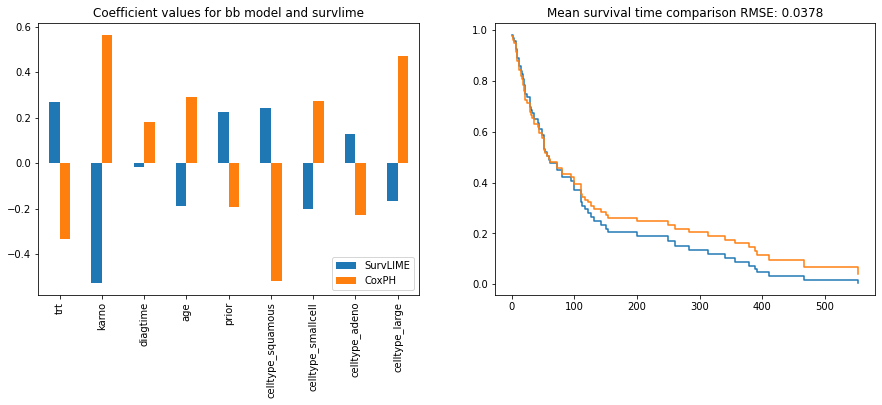

In [32]:
from survLime.utils.generic_utils import compare_survival_times

compare_survival_times(model, computation_veteran.mean().to_numpy(), train[0], train[1], test[0])

In [ ]:
# 


from sksurv.nonparametric import nelson_aalen_estimator
from functools import partial
import cvxpy as cp
from math import log
import timeit
import sklearn

# Step one
Ho_t_ = nelson_aalen_estimator(events_train, times_train)[0] # Unique times [0]; CHF [1]

columns = test[0].columns.tolist()
num_pat = 500

# Step two
explainer = survlime_tabular.LimeTabularExplainer(train[0], target_data=train[1], feature_names=columns, class_names=None,
                                                   categorical_features=None, verbose=True, mode='regression', discretize_continuous=False)

synthetic_data = explainer.data_inverse(test[0].iloc[0], num_pat) # At [0] we have the data and at [1]
                                                        #the inverse, see what is this
    
# Third step: Obtain the prediction for the synthetic data 
H_i_j = model.predict_cumulative_hazard_function(synthetic_data[1]) # X_test_t -> [371, num_features]

times_to_fill = list(set(times_train)); times_to_fill.sort()


#Ho_t_ = [fill_matrix_with_total_times(times_to_fill, times_train, list(x.x)) for x in Ho_t_]
H_i_j_wc = [fill_matrix_with_total_times(times_to_fill, x.y, list(x.x)) for x in H_i_j]